In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
# local import
from utils import read_mi, enrichment
from utils import ml_metrics, get_rbd_mutated

In [3]:
mutated = get_rbd_mutated('../out/time-filtered-lineages/')

In [4]:
df = []
for name, idir in zip(['all-notime', 1_000, 10_000,
                       100_000, 1_000_000],
                      ['../out/'] +
                      ['../out/subsets-notime/'] * 4):
    df.append(read_mi(f'{idir}{name}/mi_annotated.tsv.gz', name, date=False))
df = pd.concat(df)

In [5]:
ml = []
for name in df['name'].unique():
    tmp = df[df['name'] == name]
    ml_df = ml_metrics(tmp, mutated)
    ml_df['name'] = name
    ml.append(ml_df)
ml = pd.concat(ml)

In [6]:
ml[ml['metric'] == 'f1']

,metric,outlier,value,low,high,name
0,f1,1,0.538462,0.382979,0.689655,all-notime
1,f1,2,0.538462,0.347826,0.689655,all-notime
2,f1,3,0.636364,0.445401,0.784314,all-notime
3,f1,4,0.555556,0.344828,0.731707,all-notime
0,f1,1,0.142466,0.111421,0.182306,1000
1,f1,2,0.139303,0.101010,0.193388,1000
2,f1,3,0.256410,0.129866,0.400000,1000
3,f1,4,0.228571,0.121212,0.382992,1000
0,f1,1,0.318182,0.195122,0.442105,10000
1,f1,2,0.466667,0.307219,0.617647,10000


In [7]:
ml[ml['metric'] == 'sensitivity']

,metric,outlier,value,low,high,name
8,sensitivity,1,1.000000,NaN,NaN,all-notime
9,sensitivity,2,1.000000,NaN,NaN,all-notime
10,sensitivity,3,1.000000,NaN,0.923077,all-notime
11,sensitivity,4,0.714286,NaN,0.923077,all-notime
8,sensitivity,1,1.000000,NaN,NaN,1000
9,sensitivity,2,0.538462,0.396226,0.658425,1000
10,sensitivity,3,0.192308,0.094340,0.275065,1000
11,sensitivity,4,0.153846,0.094340,0.275065,1000
8,sensitivity,1,1.000000,NaN,NaN,10000
9,sensitivity,2,1.000000,NaN,NaN,10000


In [8]:
ml[ml['metric'] == 'specificity']

,metric,outlier,value,low,high,name
4,specificity,1,0.000000,NaN,NaN,all-notime
5,specificity,2,0.000000,NaN,NaN,all-notime
6,specificity,3,0.333333,0.166667,0.693386,all-notime
7,specificity,4,0.500000,0.166667,0.693386,all-notime
4,specificity,1,0.000000,NaN,NaN,1000
5,specificity,2,0.485623,0.447718,0.525444,1000
6,specificity,3,0.974441,0.959377,0.991961,1000
7,specificity,4,0.984026,0.959377,0.991961,1000
4,specificity,1,0.000000,NaN,NaN,10000
5,specificity,2,0.466667,0.344828,0.586681,10000


In [9]:
df.groupby('name')['pos_source'].count()

name
1000          67044
10000          2992
100000          716
1000000         496
all-notime      474
Name: pos_source, dtype: int64

In [10]:
count = df.groupby(['name', 'outlier'])['pos_source'].count().reset_index()

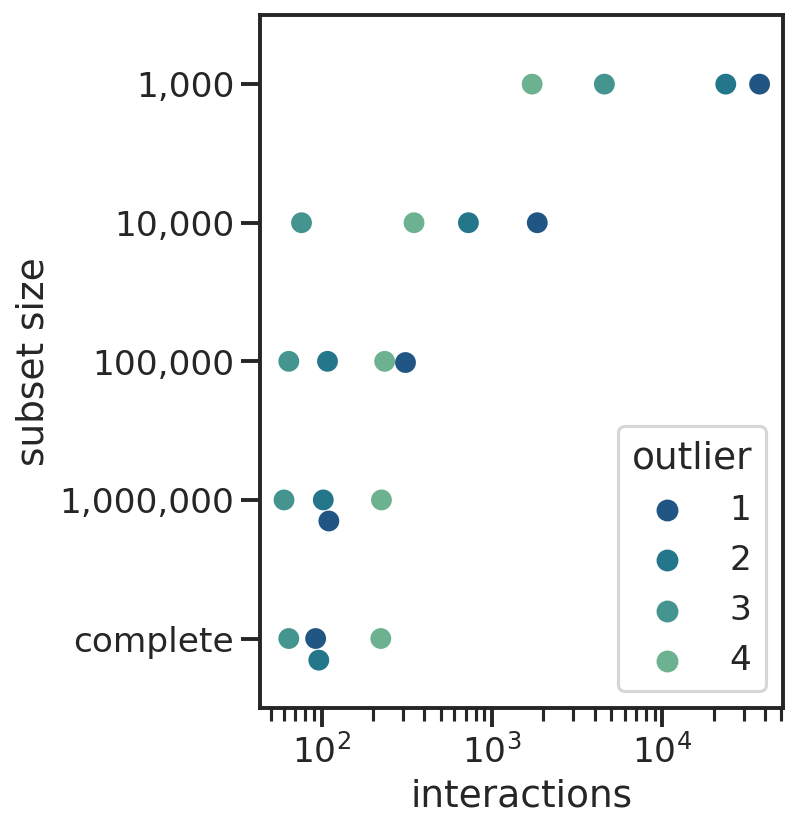

In [11]:
plt.figure(figsize=(4.5, 6))

sns.swarmplot(data=count,
              x='pos_source',
              y='name',
              hue='outlier',
              size=10,
              palette=sns.color_palette('crest_r', 4))

plt.yticks(range(5),
           ['1,000',
            '10,000',
            '100,000',
            '1,000,000',
            'complete'])

plt.legend(facecolor='w',
           title='outlier')

plt.xlabel('interactions')
plt.ylabel('subset size')

plt.xscale('log')

plt.savefig('subsets_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

1000 [10.83844978  7.00934579 17.00997206]
10000 [27.92068966 10.35251492 66.80647208]
100000 [ 64.47745358  20.71952259 184.18939394]
1000000 [ 64.47745358  20.71952259 184.18939394]


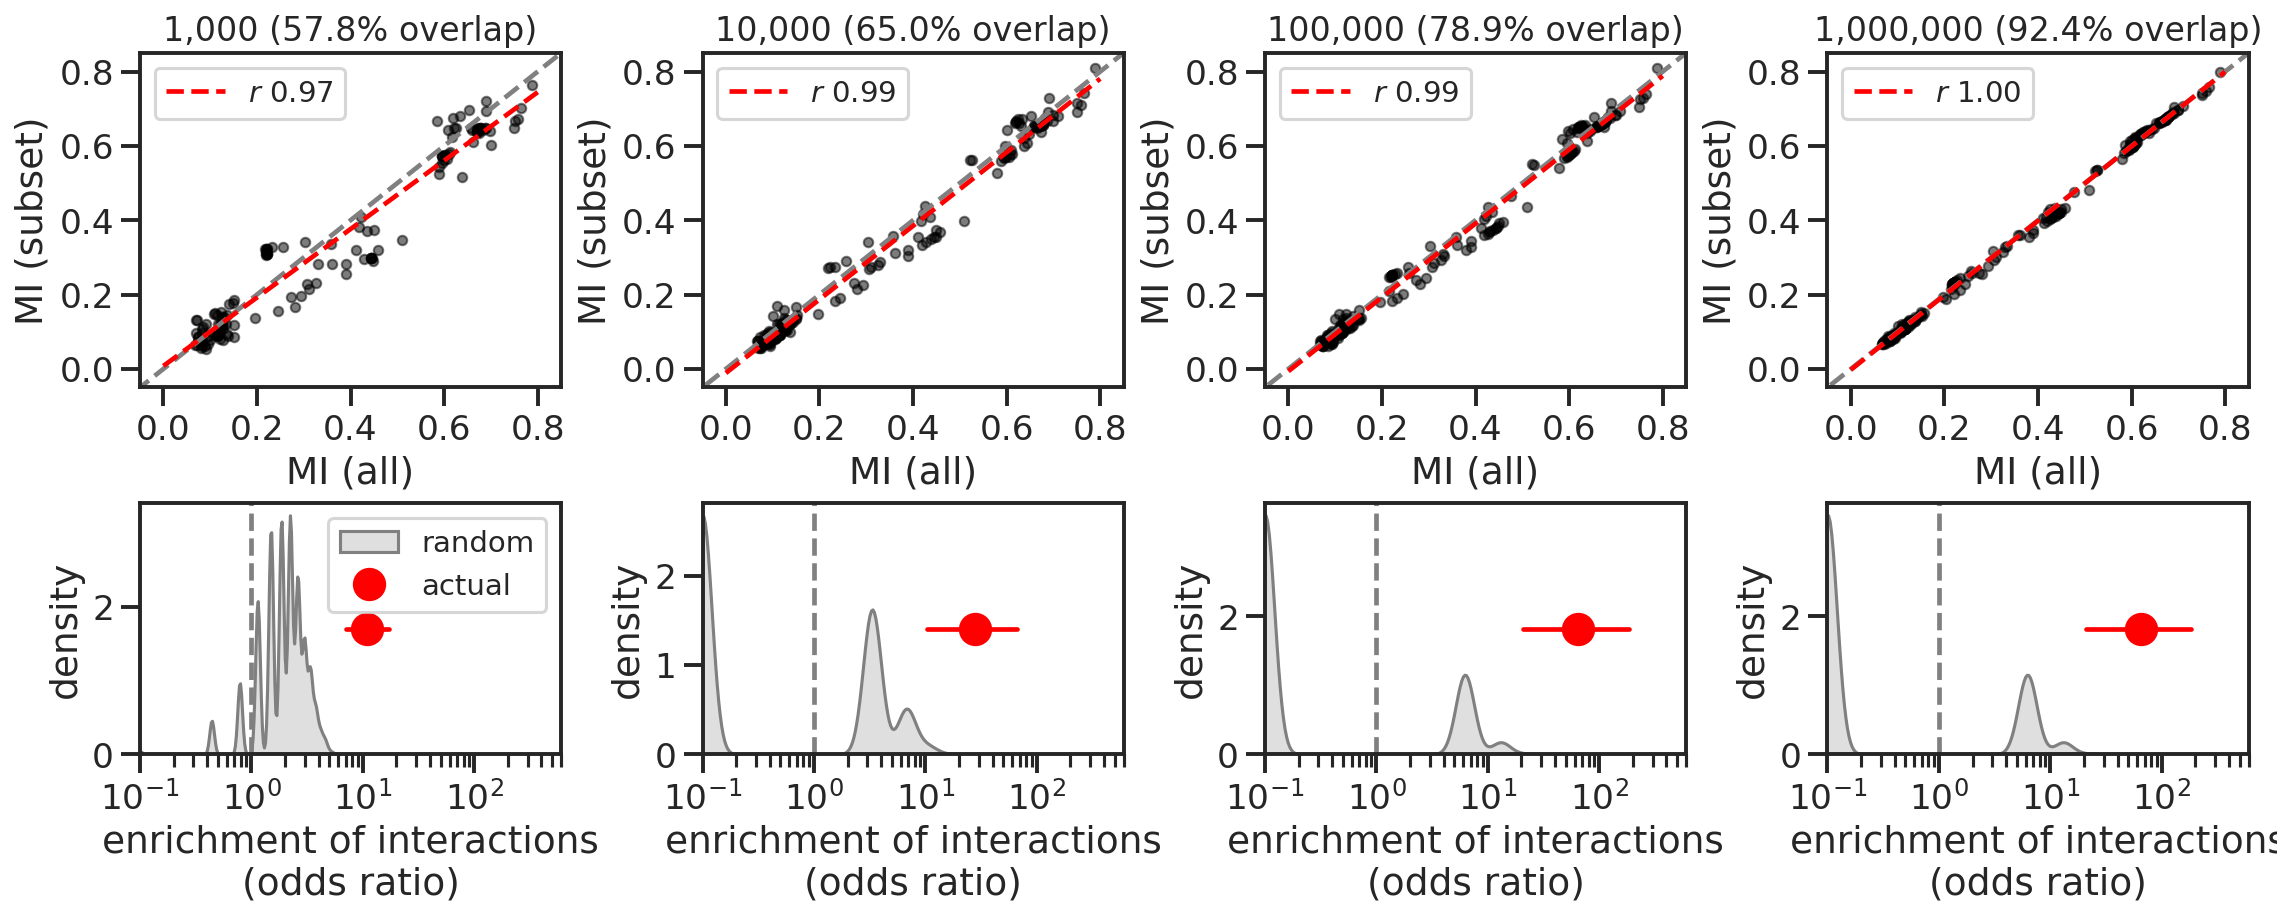

In [12]:
fig, axes = plt.subplots(2, 4,
                         figsize=(15, 6),
                         constrained_layout=True,
                         gridspec_kw = {'height_ratios':[1, 0.75]})

a = df[df['name'] == 'all-notime'].set_index(['pos_source', 'pos_target'])
for ax, subset in zip(axes.flatten(), 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset].set_index(['pos_source', 'pos_target'])
    
    idx = a.index.intersection(s.index)

    av = a.loc[idx]['mi']
    sv = s.loc[idx]['mi']
    
    ax.plot(av,
            sv,
            'k.',
            alpha=0.3,
            rasterized=True)
    ax.plot([-1, 1], [-1, 1],
            '--',
            color='grey')
    
    lr = stats.linregress(av, sv)
    
    ax.plot([0, 0.8],
            [lr.intercept,
             lr.slope * 0.8 + lr.intercept],
            'r--',
            label=f'$r$ {lr.rvalue:.2f}')
    
    ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    ax.set_ylabel('MI (subset)')
    ax.set_xlabel('MI (all)')
    
    ax.set_title(f'{subset:,} ({av.shape[0] * 100 / a.shape[0]:.1f}% overlap)',
                 fontsize=16)

for ax, subset in zip(axes.flatten()[4:], 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset]
    
    o = enrichment(s, mutated)

    print(subset,
          o[o['type'] == 'original'][
          ['odds-ratio', 'low', 'high']].values[0])
    
    sns.kdeplot(o[o['type'] != 'original']['odds-ratio'] + 0.1,
                bw_adjust=0.4,
                log_scale=True,
                color='grey', label='random',
                fill=True,
                ax=ax)
    ax.plot(o[o['type'] == 'original']['odds-ratio'].values,
            ax.get_ylim()[1] / 2,
            'ro', markersize=15,
            label='actual')
    ax.plot([o[o['type'] == 'original']['low'].values[0],
             o[o['type'] == 'original']['high'].values[0]],
            [ax.get_ylim()[1] / 2] * 2,
            'r-')
    ax.axvline(1,
               color='grey', ls='dashed')
    ax.set_ylabel('density')
    ax.set_xlabel('enrichment of interactions\n(odds ratio)')
    if subset == 1_000:
        ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(0.1, 600)

plt.savefig('subsets_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [13]:
df = df[df['outlier'] > 2].copy()

1000 [120.36138614  39.33495146 368.43939394]
10000 [119.77339901  32.02898551 448.07035176]
100000 [119.77339901  47.20582524 303.9625    ]
1000000 [104.79741379  29.35869565 336.03894472]


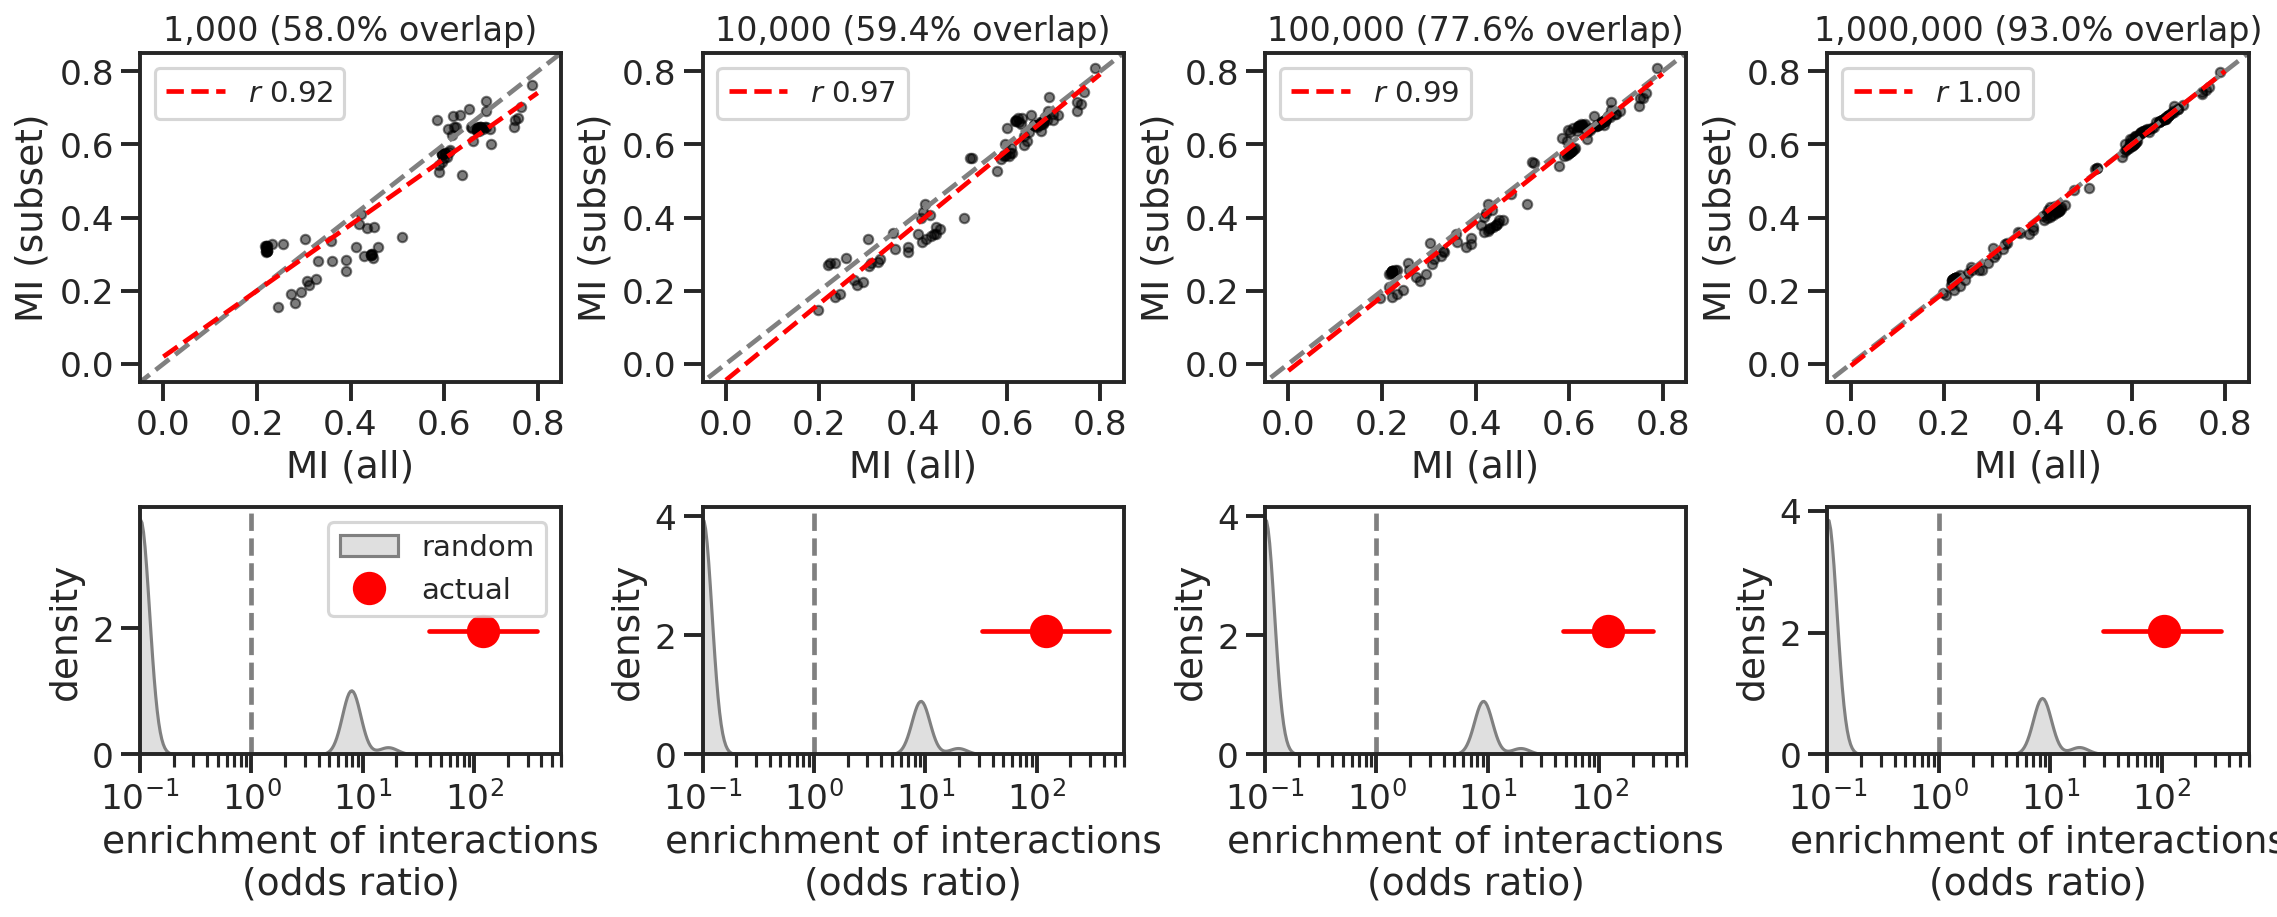

In [14]:
fig, axes = plt.subplots(2, 4,
                         figsize=(15, 6),
                         constrained_layout=True,
                         gridspec_kw = {'height_ratios':[1, 0.75]})

a = df[df['name'] == 'all-notime'].set_index(['pos_source', 'pos_target'])
for ax, subset in zip(axes.flatten(), 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset].set_index(['pos_source', 'pos_target'])
    
    idx = a.index.intersection(s.index)

    av = a.loc[idx]['mi']
    sv = s.loc[idx]['mi']
    
    ax.plot(av,
            sv,
            'k.',
            alpha=0.3,
            rasterized=True)
    ax.plot([-1, 1], [-1, 1],
            '--',
            color='grey')
    
    lr = stats.linregress(av, sv)
    
    ax.plot([0, 0.8],
            [lr.intercept,
             lr.slope * 0.8 + lr.intercept],
            'r--',
            label=f'$r$ {lr.rvalue:.2f}')
    
    ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    ax.set_ylabel('MI (subset)')
    ax.set_xlabel('MI (all)')
    
    ax.set_title(f'{subset:,} ({av.shape[0] * 100 / a.shape[0]:.1f}% overlap)',
                 fontsize=16)

for ax, subset in zip(axes.flatten()[4:], 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset]
    
    o = enrichment(s, mutated)

    print(subset,
          o[o['type'] == 'original'][
          ['odds-ratio', 'low', 'high']].values[0])
    
    sns.kdeplot(o[o['type'] != 'original']['odds-ratio'] + 0.1,
                bw_adjust=0.4,
                log_scale=True,
                color='grey', label='random',
                fill=True,
                ax=ax)
    ax.plot(o[o['type'] == 'original']['odds-ratio'].values,
            ax.get_ylim()[1] / 2,
            'ro', markersize=15,
            label='actual')
    ax.plot([o[o['type'] == 'original']['low'].values[0],
             o[o['type'] == 'original']['high'].values[0]],
            [ax.get_ylim()[1] / 2] * 2,
            'r-')
    ax.axvline(1,
               color='grey', ls='dashed')
    ax.set_ylabel('density')
    ax.set_xlabel('enrichment of interactions\n(odds ratio)')
    if subset == 1_000:
        ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(0.1, 600)

plt.savefig('subsets_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);